# Trend and growth rate analysis of CO2 data

This is a classis example of "seasonal-trend" decomposition, and an analysis of this data set is presented in the STL paper (up until about 1990).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cvx
from scipy.signal import find_peaks

In [3]:
# %matplotlib inline

# import matplotlib
# sns.set_context('paper')
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

%matplotlib notebook

In [21]:
import sys
sys.path.append('..')
from osd import Problem
from osd.components import GaussNoise, SmoothSecondDifference, SmoothFirstDifference, \
    SparseSecondDiffConvex, LinearTrend, ApproxPeriodic
SOLVER = 'MOSEK'

from statsmodels.tsa.seasonal import STL

In [5]:
data = pd.read_csv('data/co2_weekly_mlo.csv', header=47, na_values=[-999.99])

In [6]:
data['log_co2'] = np.log10(data['average'])

In [7]:
data.index = pd.to_datetime(data[['year', 'month', 'day']])

In [8]:
np.sum(np.isnan(data.average))

18

In [9]:
data.head()

,year,month,day,decimal,average,ndays,1 year ago,10 years ago,increase since 1800,log_co2
1974-05-19,1974,5,19,1974.3795,333.37,5,NaN,NaN,50.40,2.522927
1974-05-26,1974,5,26,1974.3986,332.95,6,NaN,NaN,50.06,2.522379
1974-06-02,1974,6,2,1974.4178,332.35,5,NaN,NaN,49.60,2.521596
1974-06-09,1974,6,9,1974.4370,332.20,7,NaN,NaN,49.65,2.521400
1974-06-16,1974,6,16,1974.4562,332.37,7,NaN,NaN,50.06,2.521622


In [10]:
data.tail()

,year,month,day,decimal,average,ndays,1 year ago,10 years ago,increase since 1800,log_co2
2021-05-30,2021,5,30,2021.4096,419.55,7,417.46,394.43,136.42,2.622784
2021-06-06,2021,6,6,2021.4288,419.47,7,416.54,393.69,136.65,2.622701
2021-06-13,2021,6,13,2021.4479,419.06,7,416.50,394.08,136.62,2.622276
2021-06-20,2021,6,20,2021.4671,418.33,5,416.31,393.73,136.32,2.621519
2021-06-27,2021,6,27,2021.4863,418.08,7,415.76,393.59,136.52,2.621259


<IPython.core.display.Javascript object>


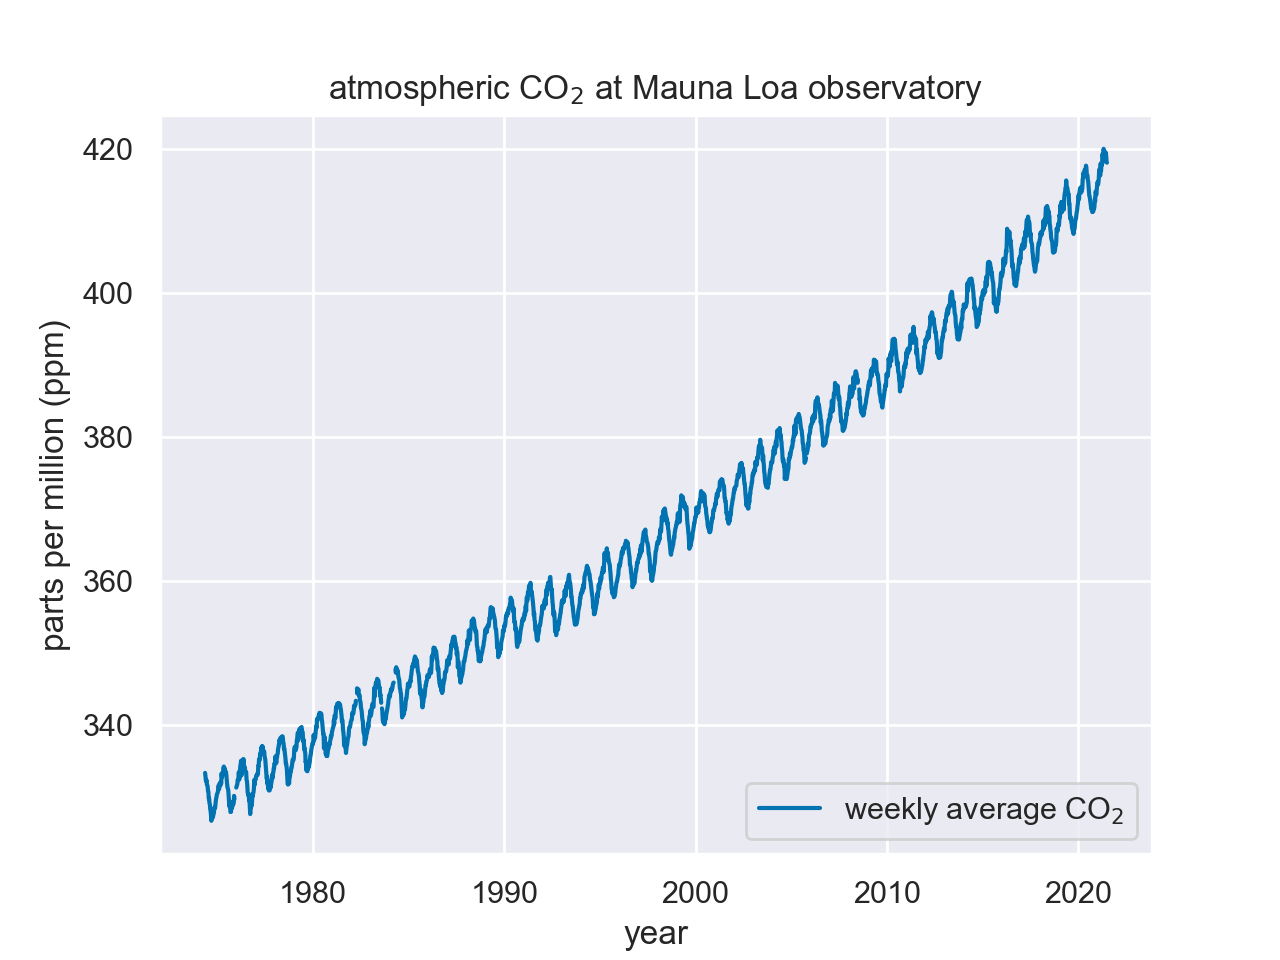

In [13]:
plt.figure()
plt.plot(data.index, data['average'], label='weekly average CO$_2$')
plt.legend(loc=4)
plt.xlabel('year')
plt.ylabel('parts per million (ppm)')
plt.title('atmospheric CO$_2$ at Mauna Loa observatory')
fig = plt.gcf()
plt.show()
# fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-Paper/figs/co2-data.pgf')

## Part 1: Comparison to STL

<IPython.core.display.Javascript object>


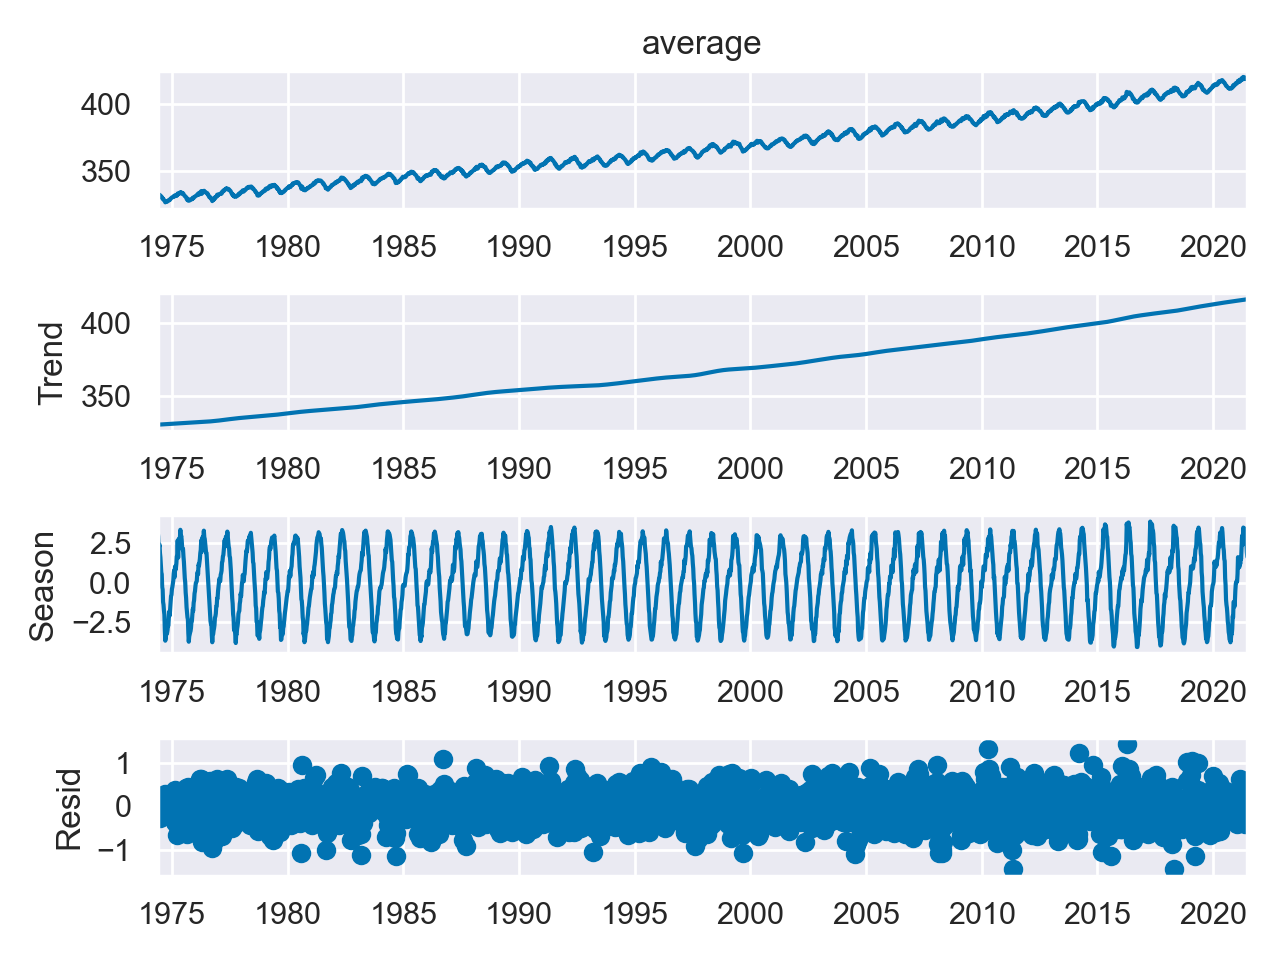

In [14]:
stl = STL(data.average.interpolate(inplace=False), period=53)
res = stl.fit()
fig = res.plot()

In [15]:
y = data['average'].values

c1 = GaussNoise()
c2 = SmoothFirstDifference(theta=5e2)
c3 = SmoothSecondDifference(theta=0, period=52)

components = [c1, c2, c3]
problem0 = Problem(y, components)

In [16]:
val0 = problem0.holdout_validation(seed=1, solver=SOLVER)
print('Model 0 error: {:.1e}'.format(val0))

Model 0 error: 2.5e+02


<IPython.core.display.Javascript object>


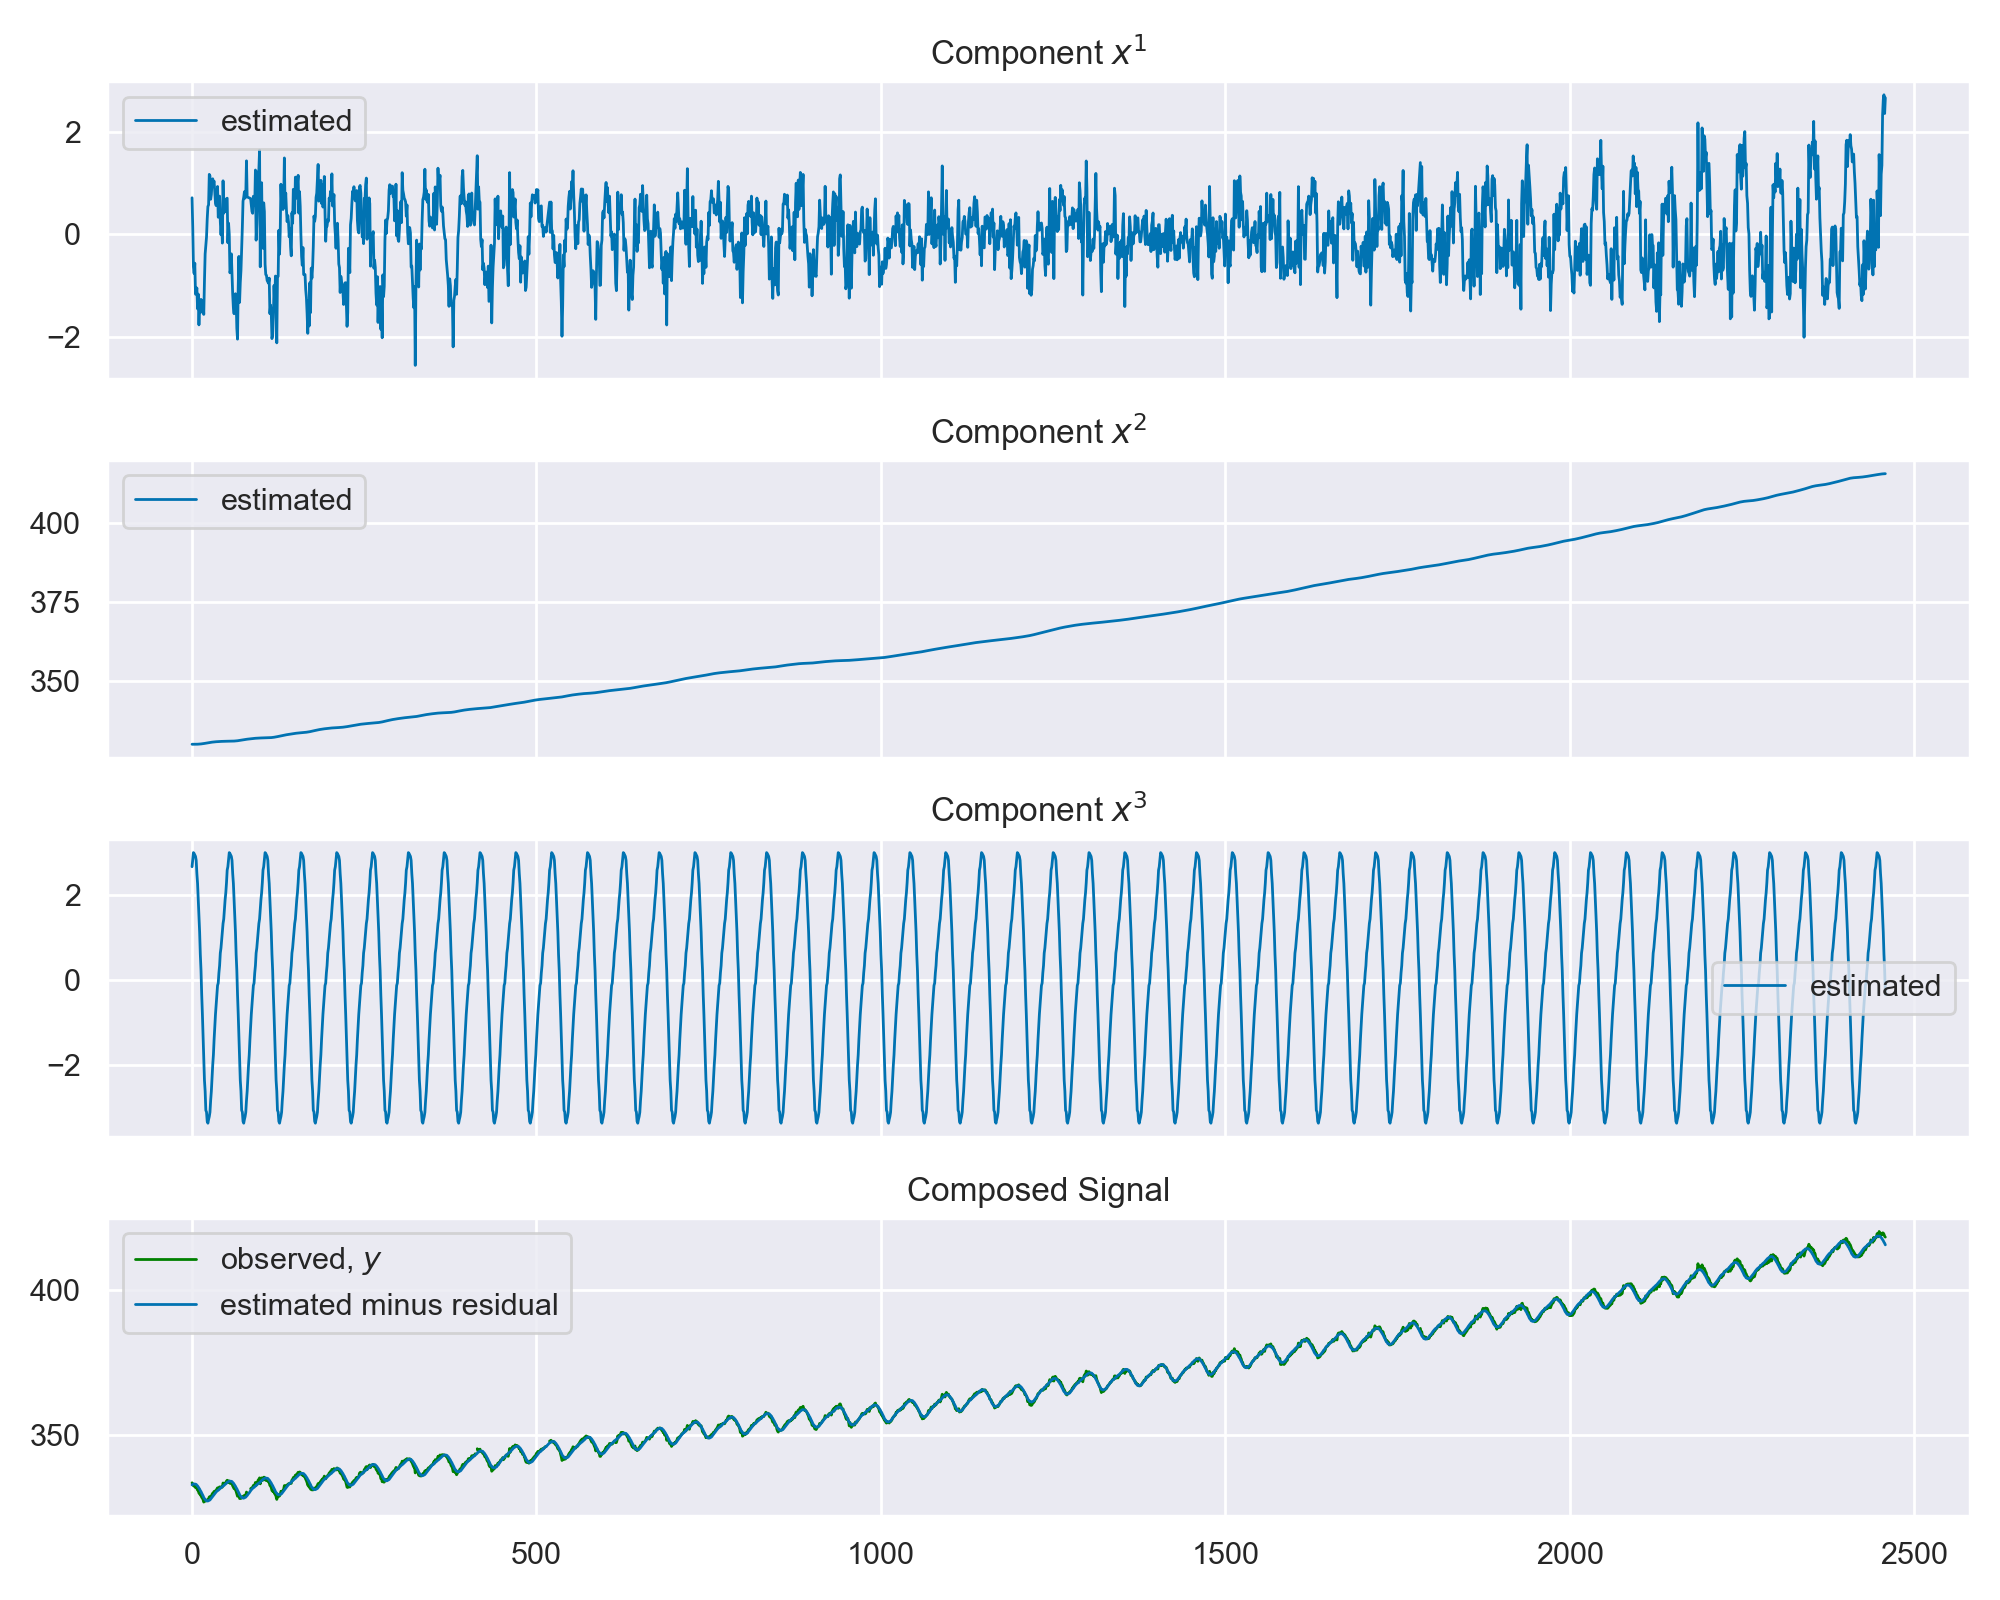

In [17]:
problem0.decompose(solver=SOLVER)
problem0.plot_decomposition();

<IPython.core.display.Javascript object>


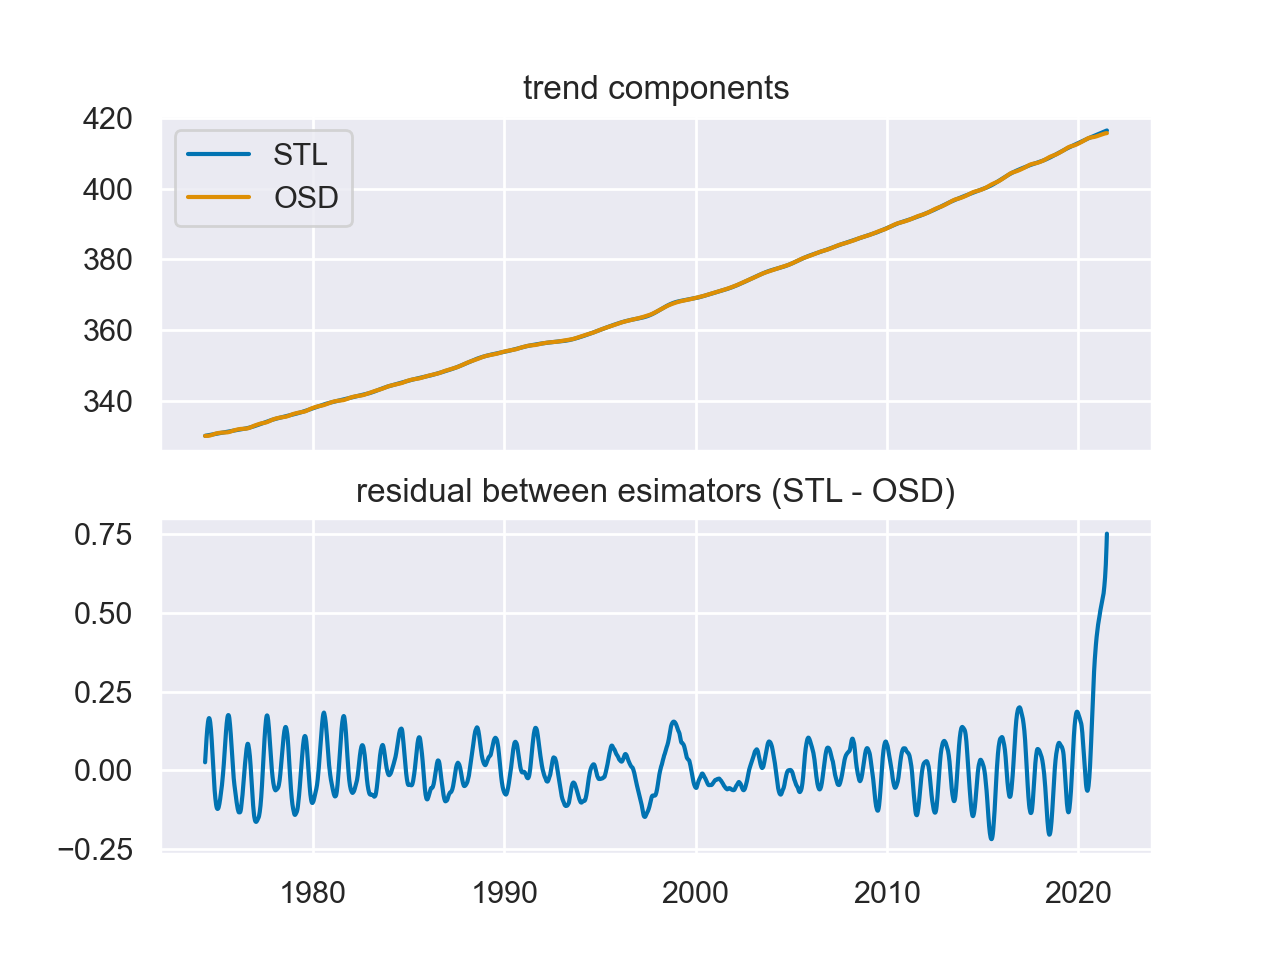

In [18]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(res.trend.index, res.trend.values, label='STL')
ax[0].plot(res.trend.index, problem0.estimates[1], label='OSD')
ax[0].set_title('trend components')
ax[0].legend()
ax[1].plot(res.trend.index, res.trend.values-problem0.estimates[1])
ax[1].set_title('residual between esimators (STL - OSD)');

<IPython.core.display.Javascript object>


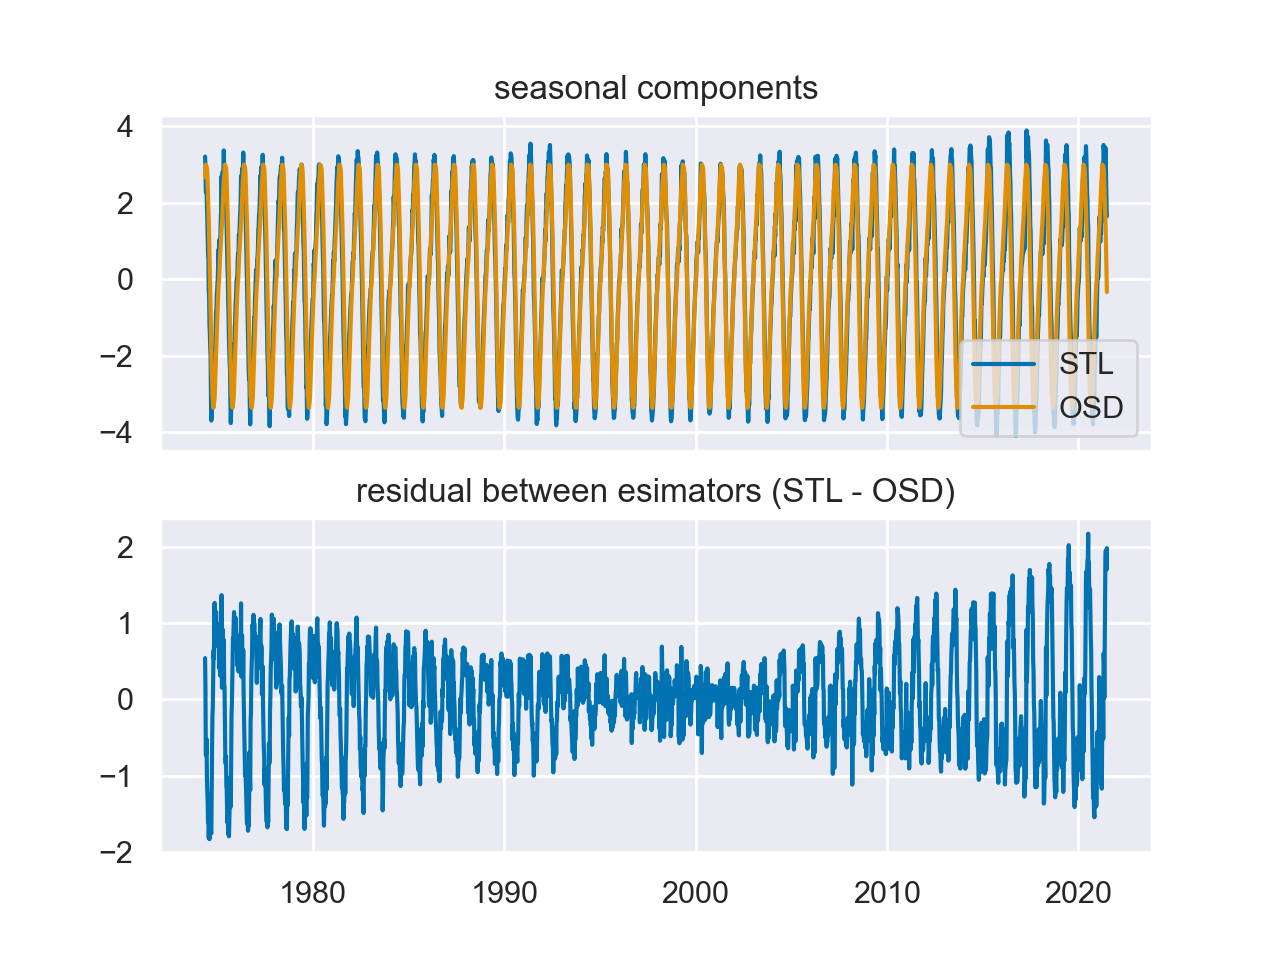

In [19]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(res.seasonal.index, res.seasonal.values, label='STL')
ax[0].plot(res.seasonal.index, problem0.estimates[2], label='OSD')
ax[0].set_title('seasonal components')
ax[0].legend()
ax[1].plot(res.seasonal.index, res.seasonal.values-problem0.estimates[2])
ax[1].set_title('residual between esimators (STL - OSD)');

<IPython.core.display.Javascript object>


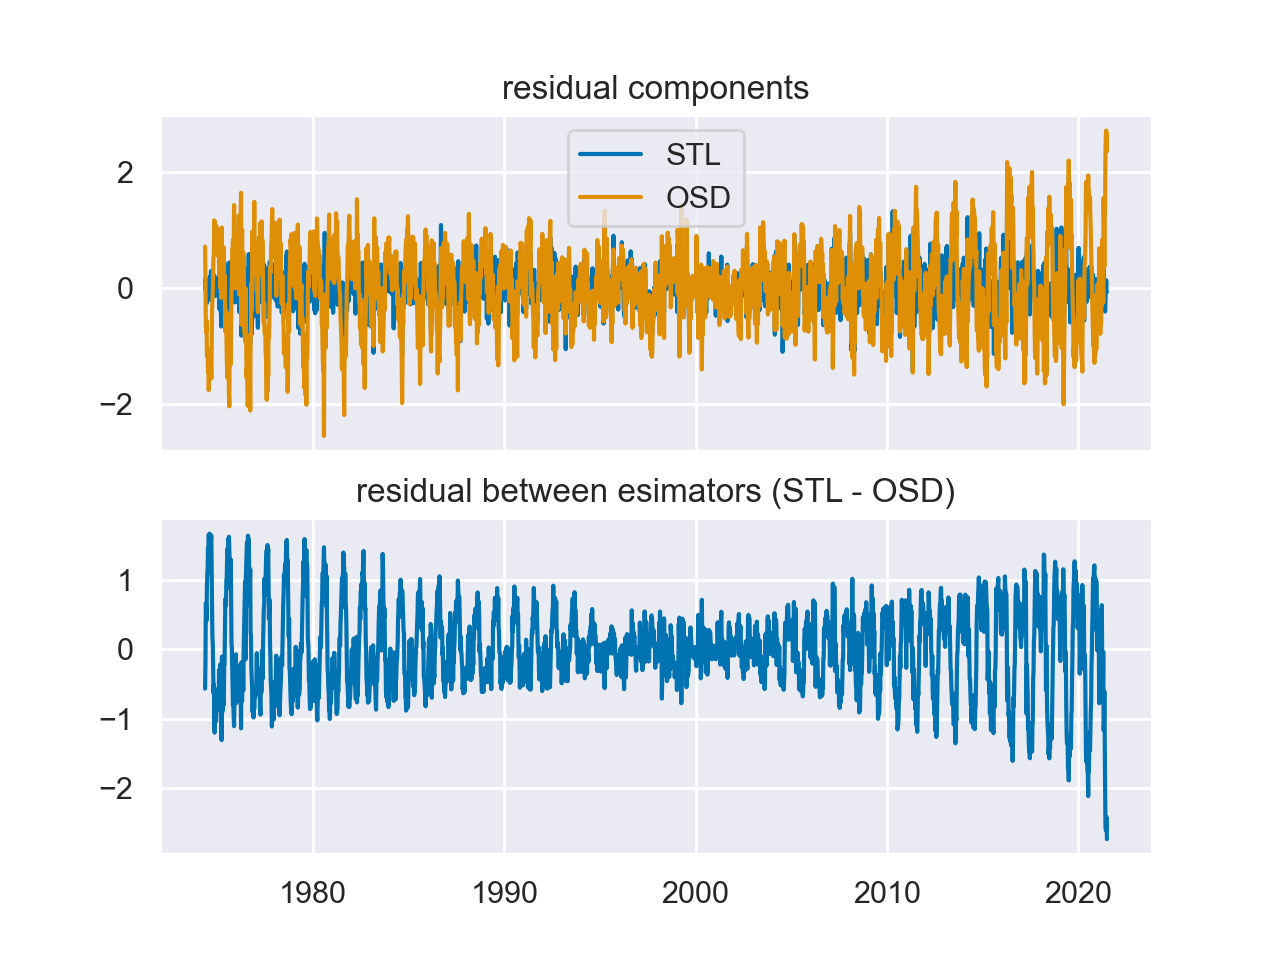

In [20]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(res.resid.index, res.resid.values, label='STL')
ax[0].plot(res.resid.index, problem0.estimates[0], label='OSD')
ax[0].set_title('residual components')
ax[0].legend()
ax[1].plot(res.resid.index, res.resid.values-problem0.estimates[0])
ax[1].set_title('residual between esimators (STL - OSD)');

## Part 2: Single growth rate versus multiple growth rates

Rather than having a generic smooth trend, try to analyze the growth rate of C02 in the atmosphere. In OSD, it is straightford to the replace the trend component in the model with a new component class. 

For this part, we take the log of the measured data, so that linear trends correspond to exponential growth curves. Then we fit a simple linear trend model, corresponding to finding an exponential growth rate that describes the entire data set. Finally we fit a piecewise linear trend model with sparse breakpoints, using the convex $\ell_1$ heuristic. We use holdout validation to show that the PWL model is a better description of the data, and we find that there are distinct growth rate periods.

In [17]:
y = data['log_co2'].values

c1 = GaussNoise()
c2 = LinearTrend()
c3 = SmoothSecondDifference(theta=0, period=52)

components = [c1, c2, c3]
problem1 = Problem(y, components)

c1 = GaussNoise()
c2 = SparseSecondDiffConvex(theta=5e1)
c3 = SmoothSecondDifference(theta=1e2, period=52)

components = [c1, c2, c3]
problem2 = Problem(y, components)

In [18]:
val1 = problem1.holdout_validation(seed=1, solver=SOLVER)
val2 = problem2.holdout_validation(seed=1, solver=SOLVER)
print('Model 1 error: {:.1e}\nModel 2 error: {:.1e}'.format(val1, val2))

Model 1 error: 2.2e-03
Model 2 error: 5.2e-04


In [19]:
problem1.decompose(solver=SOLVER)
problem2.decompose(solver=SOLVER)

<IPython.core.display.Javascript object>


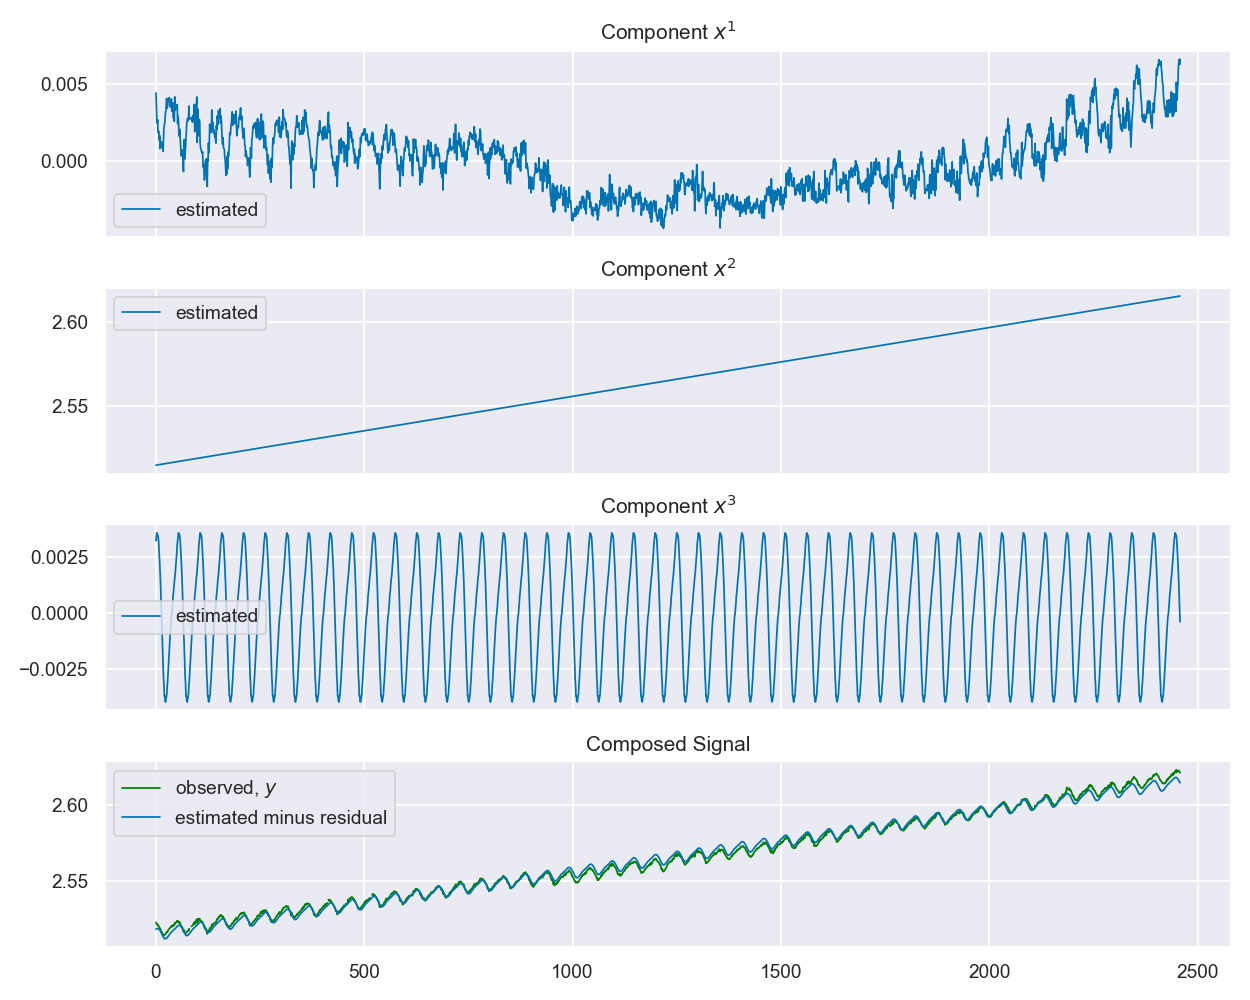

In [20]:
problem1.plot_decomposition();

<IPython.core.display.Javascript object>


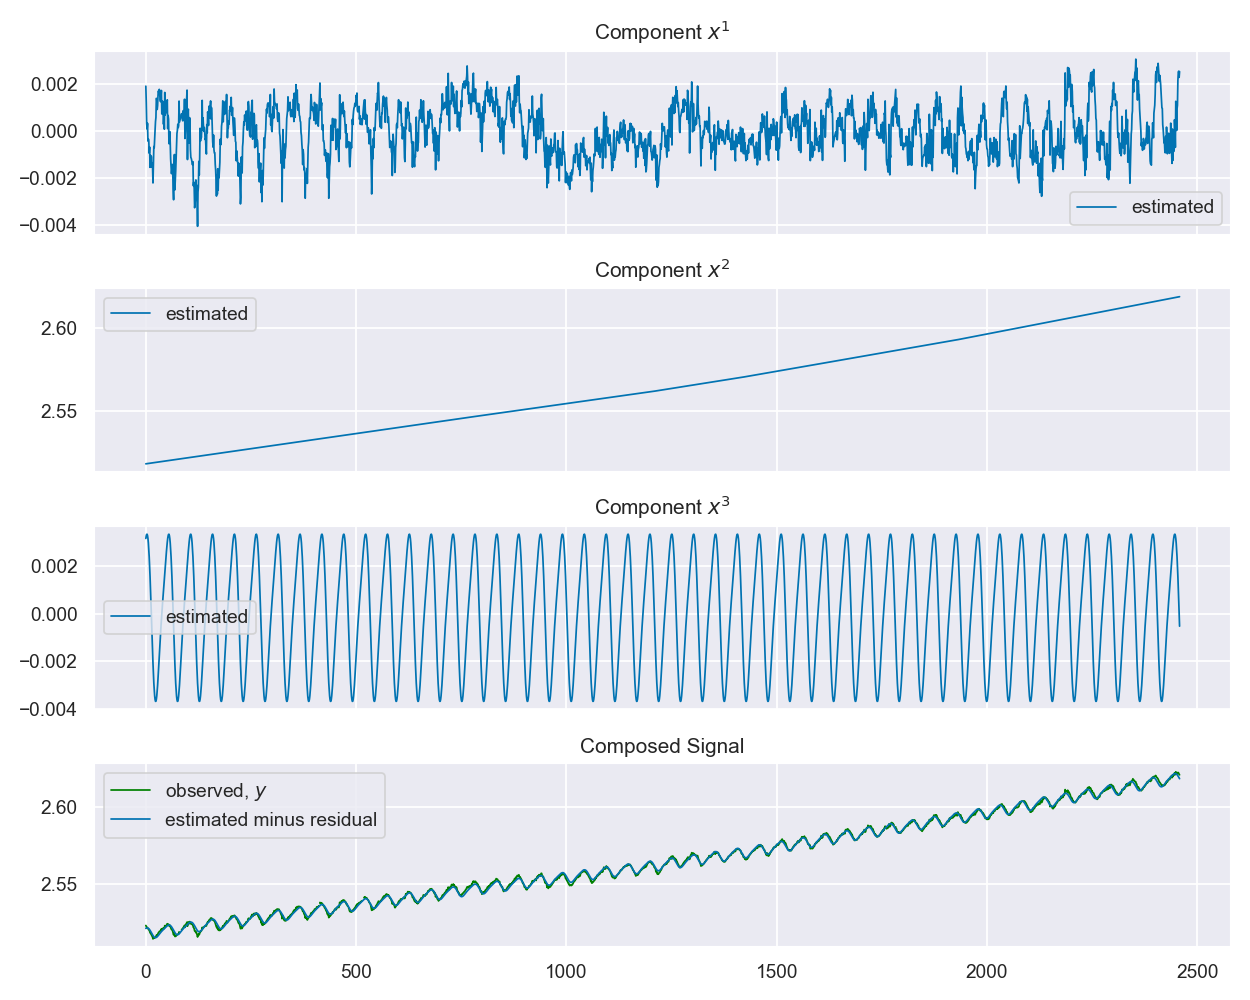

In [21]:
problem2.plot_decomposition();

In [24]:
# Calculate rate found through first model and breakpoints found in second model

single_rate = np.average(np.diff(problem1.estimates[1]))
peaks, heights = find_peaks(np.abs(np.diff(problem2.estimates[1], n=2)) 
                            / np.max(np.abs(np.diff(problem2.estimates[1], n=2))), 
                            height=0.02, distance=10)

<IPython.core.display.Javascript object>


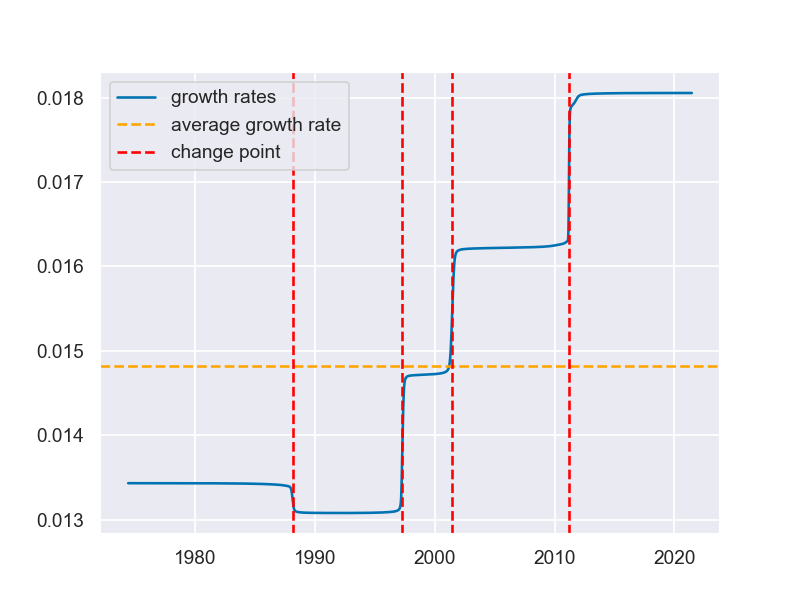

In [22]:
plt.figure()
scale = 1. / 365
plt.plot(data['decimal'][:-1], np.diff(problem2.estimates[1] / scale, n=1), label='growth rates')
plt.axhline(single_rate / scale, color='orange', ls='--', label='average growth rate')
for ix, p in enumerate(peaks):
    l = data['decimal'][p]
    if ix == 0:
        plt.axvline(l, color='red', ls='--', label='change point')
    else:
        plt.axvline(l, color='red', ls='--')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


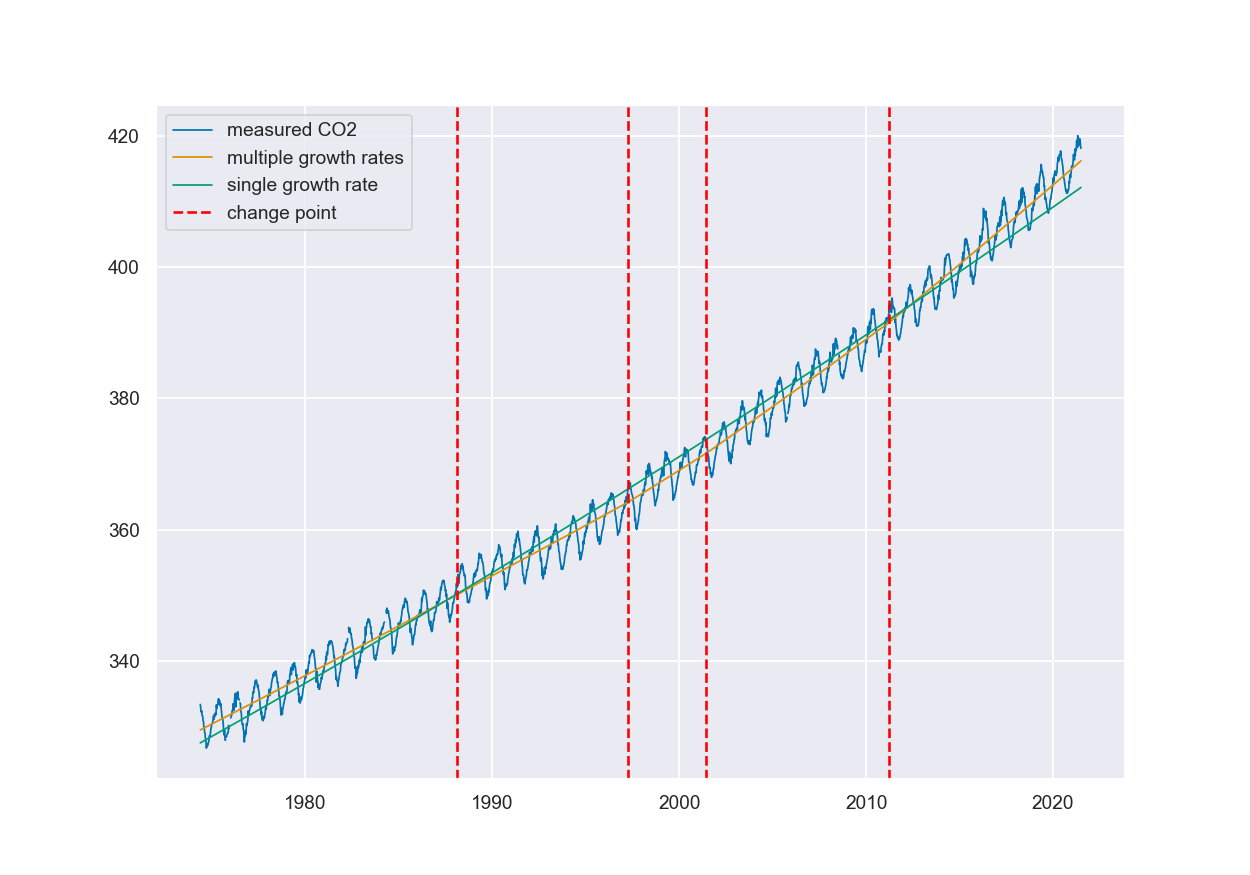

In [25]:

plt.figure(figsize=(10,7))
plt.plot(data['decimal'], 10**y, label='measured CO2', linewidth=1)
plt.plot(data['decimal'], 10**problem2.estimates[1], label='multiple growth rates', linewidth=1)
plt.plot(data['decimal'], 10**(problem1.estimates[1]), label='single growth rate', linewidth=1)
# for l in np.arange(T)[np.r_[[False], np.abs(1e6 * np.diff(x[1].value, n=2)) >= 0.1, [False]]]:
#     plt.axvline(l)
for ix, p in enumerate(peaks):
    l = data['decimal'][p]
    if ix == 0:
        plt.axvline(l, color='red', ls='--', label='change point')
    else:
        plt.axvline(l, color='red', ls='--')
plt.legend()
plt.show()